https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab

## Importar librerias 

In [1]:
import pandas as pd
import re
import nltk
from nltk import FreqDist
from nltk import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import io
from gensim.models import word2vec
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
import pickle
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Proyectos_Ley_Congreso/notebooks")

In [0]:
import sys
sys.path.append('../src/')
from filter_words import run_stopword_statistics
from filter_words import make_stopwords_filter
from filter_words import remove_stopwords_from_list_texts

## Cargar la data 

In [4]:
data=pd.read_pickle("../data/intermediated/dataIntegrated.pkl")
data["NroPaginas"]=data["NroPaginas"].astype("int32")
print(data.shape)
data.head()

(4827, 19)


,codigo,fechUlt,fechPres,estado,tituloProy,linkProy,periodo,legislatura,proponente,grupoParlamentario,sumilla,autores,seguimiento,inicAgrupadas,urlPdf,Archivo_Origen,Fecha,NroPaginas,Texto
index,,,,,,,,,,,,,,,,,,,
4849,04849/2019-CR,10/09/2019,09/30/2019,Decretado a...,"LEY DE REFORMA CONSTITUCIONAL, QUE ESTABLECE L...",http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,"Frente Amplio por Justicia, Vida y Libertad",Propone modificar el artículo 134 de la Const...,"[Morales Ramírez Edyson Humberto, Foronda Far...",09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484920190930.pdf,2019-09-30,11,Qº“ XCA DEL\n\nº;.\n\nm\n\n5'…»3 Ae Proyecto d...
4848,04848/2019-PE,10/10/2019,09/30/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE CONCEDE LA NACIONAL...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone conceder la nacionalidad peruana a lo...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484820190930.pdf,2019-09-30,5,aT N“….ÍL.€2.LÍ PA de\n\nCONGRESO DE LA REPÚBL...
4847,04847/2019-PE,10/09/2019,09/30/2019,Decretado a...,LEY QUE MODIFICA EL ARTÍCULO 8 DE LA LEY 28301...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone modificar el artículo 8 de la Ley 283...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484720190930.pdf,2019-09-30,22,CONGRESO DE LA REPÚBLICA\nÁREA DE TRAMITE DOCU...
4846,04846/2019-PE,10/10/2019,09/27/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE MODIFICA EL ANEXO D...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone Resolución Legislativa que modifica e...,[],"04/10/2019 Decretado a... Defensa Nacional, O...",None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484620190927.pdf,2019-09-27,15,Proyecto de Resolución Legistativa N”... 731 6...
4845,04845/2019-CR,10/10/2019,09/25/2019,En comisión,LEY QUE DECLARA DE INTERÉS NACIONAL Y NECESIDA...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,Contigo,Propone declarar de interés nacional y necesi...,"[Violeta López Gilbert Félix, Castro Bravo J...",04/10/2019 Decretado a... Transportes y Comun...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484520190925.pdf,2019-09-25,7,....... CONGRESO DE LA REPÚBLICA\nPÍO)'€CÍO d€...


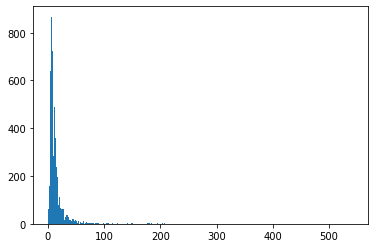

In [5]:
plt.hist(data["NroPaginas"],bins=300)
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

In [6]:
data["NroPaginas"].describe()

count    4827.000000
mean       16.192459
std        25.869497
min         1.000000
25%         7.000000
50%        10.000000
75%        16.000000
max       542.000000
Name: NroPaginas, dtype: float64

In [7]:
np.quantile(data["NroPaginas"],q=0.025), np.quantile(data["NroPaginas"],q=0.975)

(4.0, 66.0)

In [8]:
data=data[(data["NroPaginas"]>=4) & (data["NroPaginas"]<=66)]
print(data.shape)
data.head()

(4617, 19)


,codigo,fechUlt,fechPres,estado,tituloProy,linkProy,periodo,legislatura,proponente,grupoParlamentario,sumilla,autores,seguimiento,inicAgrupadas,urlPdf,Archivo_Origen,Fecha,NroPaginas,Texto
index,,,,,,,,,,,,,,,,,,,
4849,04849/2019-CR,10/09/2019,09/30/2019,Decretado a...,"LEY DE REFORMA CONSTITUCIONAL, QUE ESTABLECE L...",http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,"Frente Amplio por Justicia, Vida y Libertad",Propone modificar el artículo 134 de la Const...,"[Morales Ramírez Edyson Humberto, Foronda Far...",09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484920190930.pdf,2019-09-30,11,Qº“ XCA DEL\n\nº;.\n\nm\n\n5'…»3 Ae Proyecto d...
4848,04848/2019-PE,10/10/2019,09/30/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE CONCEDE LA NACIONAL...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone conceder la nacionalidad peruana a lo...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484820190930.pdf,2019-09-30,5,aT N“….ÍL.€2.LÍ PA de\n\nCONGRESO DE LA REPÚBL...
4847,04847/2019-PE,10/09/2019,09/30/2019,Decretado a...,LEY QUE MODIFICA EL ARTÍCULO 8 DE LA LEY 28301...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone modificar el artículo 8 de la Ley 283...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484720190930.pdf,2019-09-30,22,CONGRESO DE LA REPÚBLICA\nÁREA DE TRAMITE DOCU...
4846,04846/2019-PE,10/10/2019,09/27/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE MODIFICA EL ANEXO D...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone Resolución Legislativa que modifica e...,[],"04/10/2019 Decretado a... Defensa Nacional, O...",None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484620190927.pdf,2019-09-27,15,Proyecto de Resolución Legistativa N”... 731 6...
4845,04845/2019-CR,10/10/2019,09/25/2019,En comisión,LEY QUE DECLARA DE INTERÉS NACIONAL Y NECESIDA...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,Contigo,Propone declarar de interés nacional y necesi...,"[Violeta López Gilbert Félix, Castro Bravo J...",04/10/2019 Decretado a... Transportes y Comun...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484520190925.pdf,2019-09-25,7,....... CONGRESO DE LA REPÚBLICA\nPÍO)'€CÍO d€...


## Limpieza de Texto

In [9]:
def remove(news):
    clean_news = []
    for new in news:
        sin_guiones=re.sub('(\S)-\n', r'\1', new.lower()) ### sin guiones
        sin_character = re.sub(r'[^\w\s]', '', sin_guiones) ##busca los signos, caracteristicas especiales
        sin_numero = re.sub("\d+", "", sin_character)##busca los numeros y los elimina
        sin_tildes=sin_numero.translate(str.maketrans('áéíóúü','aeiouu'))
        sin_tildes = " ".join([i for i in sin_tildes.split() if len(i)>2])##solo palabras que tengan mas de tres caracteres
        clean_news.append(sin_tildes)     
    return clean_news
data["Clean_Texts"]=remove(data["Texto"])
print(data.shape)
data.head()

(4617, 20)


,codigo,fechUlt,fechPres,estado,tituloProy,linkProy,periodo,legislatura,proponente,grupoParlamentario,sumilla,autores,seguimiento,inicAgrupadas,urlPdf,Archivo_Origen,Fecha,NroPaginas,Texto,Clean_Texts
index,,,,,,,,,,,,,,,,,,,,
4849,04849/2019-CR,10/09/2019,09/30/2019,Decretado a...,"LEY DE REFORMA CONSTITUCIONAL, QUE ESTABLECE L...",http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,"Frente Amplio por Justicia, Vida y Libertad",Propone modificar el artículo 134 de la Const...,"[Morales Ramírez Edyson Humberto, Foronda Far...",09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484920190930.pdf,2019-09-30,11,Qº“ XCA DEL\n\nº;.\n\nm\n\n5'…»3 Ae Proyecto d...,xca del proyecto ley loncrso congreso republic...
4848,04848/2019-PE,10/10/2019,09/30/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE CONCEDE LA NACIONAL...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone conceder la nacionalidad peruana a lo...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484820190930.pdf,2019-09-30,5,aT N“….ÍL.€2.LÍ PA de\n\nCONGRESO DE LA REPÚBL...,nilli congreso republica area tramite document...
4847,04847/2019-PE,10/09/2019,09/30/2019,Decretado a...,LEY QUE MODIFICA EL ARTÍCULO 8 DE LA LEY 28301...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone modificar el artículo 8 de la Ley 283...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484720190930.pdf,2019-09-30,22,CONGRESO DE LA REPÚBLICA\nÁREA DE TRAMITE DOCU...,congreso republica area tramite documentario o...
4846,04846/2019-PE,10/10/2019,09/27/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE MODIFICA EL ANEXO D...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone Resolución Legislativa que modifica e...,[],"04/10/2019 Decretado a... Defensa Nacional, O...",None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484620190927.pdf,2019-09-27,15,Proyecto de Resolución Legistativa N”... 731 6...,proyecto resolucion legistativa congreso repub...
4845,04845/2019-CR,10/10/2019,09/25/2019,En comisión,LEY QUE DECLARA DE INTERÉS NACIONAL Y NECESIDA...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,Contigo,Propone declarar de interés nacional y necesi...,"[Violeta López Gilbert Félix, Castro Bravo J...",04/10/2019 Decretado a... Transportes y Comun...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484520190925.pdf,2019-09-25,7,....... CONGRESO DE LA REPÚBLICA\nPÍO)'€CÍO d€...,congreso republica piocio ley ecco ouc sep pro...


## Remover Stopwords

In [10]:
Stopwords=stopwords.words("spanish") ### obtener la lista de stopwords en idioma español
Stopwords=[i.translate(str.maketrans('áéíóúü','aeiouu')) for i in Stopwords]
def remove_stopwords(news):
    sin_stopwords=[]
    for new in news:
        content=[word for word in new.split() if word not in Stopwords]
        sin_stopwords.append(" ".join(content))
    return sin_stopwords
data["Clean_Stopwords"]=remove_stopwords(data["Clean_Texts"])
print(data.shape)
data.head()

(4617, 21)


,codigo,fechUlt,fechPres,estado,tituloProy,linkProy,periodo,legislatura,proponente,grupoParlamentario,sumilla,autores,seguimiento,inicAgrupadas,urlPdf,Archivo_Origen,Fecha,NroPaginas,Texto,Clean_Texts,Clean_Stopwords
index,,,,,,,,,,,,,,,,,,,,,
4849,04849/2019-CR,10/09/2019,09/30/2019,Decretado a...,"LEY DE REFORMA CONSTITUCIONAL, QUE ESTABLECE L...",http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,"Frente Amplio por Justicia, Vida y Libertad",Propone modificar el artículo 134 de la Const...,"[Morales Ramírez Edyson Humberto, Foronda Far...",09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484920190930.pdf,2019-09-30,11,Qº“ XCA DEL\n\nº;.\n\nm\n\n5'…»3 Ae Proyecto d...,xca del proyecto ley loncrso congreso republic...,xca proyecto ley loncrso congreso republica ar...
4848,04848/2019-PE,10/10/2019,09/30/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE CONCEDE LA NACIONAL...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone conceder la nacionalidad peruana a lo...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484820190930.pdf,2019-09-30,5,aT N“….ÍL.€2.LÍ PA de\n\nCONGRESO DE LA REPÚBL...,nilli congreso republica area tramite document...,nilli congreso republica area tramite document...
4847,04847/2019-PE,10/09/2019,09/30/2019,Decretado a...,LEY QUE MODIFICA EL ARTÍCULO 8 DE LA LEY 28301...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone modificar el artículo 8 de la Ley 283...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484720190930.pdf,2019-09-30,22,CONGRESO DE LA REPÚBLICA\nÁREA DE TRAMITE DOCU...,congreso republica area tramite documentario o...,congreso republica area tramite documentario o...
4846,04846/2019-PE,10/10/2019,09/27/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE MODIFICA EL ANEXO D...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone Resolución Legislativa que modifica e...,[],"04/10/2019 Decretado a... Defensa Nacional, O...",None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484620190927.pdf,2019-09-27,15,Proyecto de Resolución Legistativa N”... 731 6...,proyecto resolucion legistativa congreso repub...,proyecto resolucion legistativa congreso repub...
4845,04845/2019-CR,10/10/2019,09/25/2019,En comisión,LEY QUE DECLARA DE INTERÉS NACIONAL Y NECESIDA...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,Contigo,Propone declarar de interés nacional y necesi...,"[Violeta López Gilbert Félix, Castro Bravo J...",04/10/2019 Decretado a... Transportes y Comun...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484520190925.pdf,2019-09-25,7,....... CONGRESO DE LA REPÚBLICA\nPÍO)'€CÍO d€...,congreso republica piocio ley ecco ouc sep pro...,congreso republica piocio ley ecco ouc sep pro...


## information theoretic approach to the identification of stopwords

In [11]:
list_texts = [[h.strip() for h in doc.split()  ] for doc in data["Clean_Stopwords"]]
## path to a manual stopword list (this one is from mallet)
# path_stopword_list =  ruta+"Datos/stopwords-es.txt"
## nudfmber of realizations for the random null model
N_s = 1000
## get the statistics
df = run_stopword_statistics(list_texts,N_s=N_s)
## look at the entries
df.sort_values(by='F',ascending=False).head()

,F,I,tfidf,H,H-tilde,H-tilde_std,N
ley,0.014896,0.074414,0.027431,11.691177,11.765592,0.002829,145995
articulo,0.009501,0.104988,0.000000,11.647461,11.752449,0.003752,93121
nacional,0.008072,0.173035,0.135187,11.572830,11.745865,0.003926,79114
republica,0.007677,-0.038041,0.003531,11.781684,11.743643,0.004058,75244
congreso,0.005867,0.036298,0.008100,11.692711,11.729008,0.004439,57500


In [0]:
df.to_pickle("../data/intermediated/stopwords_statistics.pkl")

In [13]:
df

,F,I,tfidf,H,H-tilde,H-tilde_std,N
___,2.999754e-05,0.182953,3.287035,7.911390,8.094344,0.026993,294
____,6.530076e-06,0.008519,4.362530,5.968750,5.977269,0.026406,64
_____,5.407719e-06,0.018565,4.572531,5.690185,5.708750,0.027618,53
______,4.489427e-06,0.028704,4.785051,5.413977,5.442681,0.027670,44
_______,2.448778e-06,0.189954,5.832500,4.386842,4.576796,0.026140,24
...,...,...,...,...,...,...,...
ññlf,1.020324e-07,0.000000,8.437500,0.000000,0.000000,0.000000,1
ññlhgg,1.020324e-07,0.000000,8.437500,0.000000,0.000000,0.000000,1
ñños,1.020324e-07,0.000000,8.437500,0.000000,0.000000,0.000000,1
ññu,1.020324e-07,0.000000,8.437500,0.000000,0.000000,0.000000,1


In [0]:
## seleccionando el metodo de remover stopwords
method = 'INFOR'
cutoff_type = 'p'
cutoff_val = 0.60
df_filter = make_stopwords_filter(df,
                                  method = method,
                                  cutoff_type = cutoff_type, 
                                  cutoff_val = cutoff_val, )

In [24]:
df_filter

,F-cumsum,S
confiere,0.000291,-0.680438
exposicion,0.000877,-0.661164
pase,0.001297,-0.656571
def,0.001515,-0.626118
motivos,0.002138,-0.608753
...,...,...
congenita,0.599718,1.130303
molle,0.599719,1.130470
jomadas,0.599720,1.130470
divergencia,0.599722,1.130530


In [15]:
## get the list of words from df_filter and get a filtered list_of_texts
list_words_filter = list(df_filter.index)
list_texts_filter = remove_stopwords_from_list_texts(list_texts, list_words_filter)
print('Original text:', list_texts[0])
print('Filtered text:', list_texts_filter[0])
N = sum([ len(doc) for doc in list_texts ])
N_filter = sum([ len(doc) for doc in list_texts_filter ])
print('Remaining fraction of tokens',N_filter/N)

Original text: ['xca', 'proyecto', 'ley', 'loncrso', 'congreso', 'republica', 'area', 'tramite', 'documentario', 'proyecto', 'ley', 'reforma', 'constitucional', 'establece', 'disolucion', 'congreso', 'promueve', 'convocatoria', 'elecciones', 'generales', 'anticipadas', 'sep', 'corigresistas', 'republica', 'suscriben', 'iniciativa', 'congresista', 'edyson', 'humberto', 'morales', 'ramirez', 'miembro', 'bancada', 'frente', 'amplio', 'conformidad', 'señalado', 'articulo', 'constitucion', 'politica', 'peru', 'asi', 'articulos', 'reglamento', 'congreso', 'republica', 'presenta', 'siguiente', 'proyecto', 'ley', 'formula', 'legal', 'proyecto', 'ley', 'reforma', 'constitucional', 'establece', 'disolucion', 'congreso', 'promueve', 'convocatoria', 'elecciones', 'generales', 'anticipadas', 'articulo', 'objeto', 'ley', 'presente', 'ley', 'objeto', 'reformar', 'parcialmente', 'constitucion', 'politica', 'peru', 'fin', 'establecer', 'supuestos', 'habilitar', 'presidente', 'disuelva', 'congreso', 're

In [16]:
data["Clean_stopword_infor"]=[" ".join(i).strip() for i in list_texts_filter]
data.head()

,codigo,fechUlt,fechPres,estado,tituloProy,linkProy,periodo,legislatura,proponente,grupoParlamentario,sumilla,autores,seguimiento,inicAgrupadas,urlPdf,Archivo_Origen,Fecha,NroPaginas,Texto,Clean_Texts,Clean_Stopwords,Clean_stopword_infor
index,,,,,,,,,,,,,,,,,,,,,,
4849,04849/2019-CR,10/09/2019,09/30/2019,Decretado a...,"LEY DE REFORMA CONSTITUCIONAL, QUE ESTABLECE L...",http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,"Frente Amplio por Justicia, Vida y Libertad",Propone modificar el artículo 134 de la Const...,"[Morales Ramírez Edyson Humberto, Foronda Far...",09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484920190930.pdf,2019-09-30,11,Qº“ XCA DEL\n\nº;.\n\nm\n\n5'…»3 Ae Proyecto d...,xca del proyecto ley loncrso congreso republic...,xca proyecto ley loncrso congreso republica ar...,reforma constitucional disolucion convocatoria...
4848,04848/2019-PE,10/10/2019,09/30/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE CONCEDE LA NACIONAL...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone conceder la nacionalidad peruana a lo...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484820190930.pdf,2019-09-30,5,aT N“….ÍL.€2.LÍ PA de\n\nCONGRESO DE LA REPÚBL...,nilli congreso republica area tramite document...,nilli congreso republica area tramite document...,decenio igualdad oportunidades hombres lucha c...
4847,04847/2019-PE,10/09/2019,09/30/2019,Decretado a...,LEY QUE MODIFICA EL ARTÍCULO 8 DE LA LEY 28301...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone modificar el artículo 8 de la Ley 283...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484720190930.pdf,2019-09-30,22,CONGRESO DE LA REPÚBLICA\nÁREA DE TRAMITE DOCU...,congreso republica area tramite documentario o...,congreso republica area tramite documentario o...,señor mesa partes pedro carlos presidente voto...
4846,04846/2019-PE,10/10/2019,09/27/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE MODIFICA EL ANEXO D...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone Resolución Legislativa que modifica e...,[],"04/10/2019 Decretado a... Defensa Nacional, O...",None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484620190927.pdf,2019-09-27,15,Proyecto de Resolución Legistativa N”... 731 6...,proyecto resolucion legistativa congreso repub...,proyecto resolucion legistativa congreso repub...,decenio igualdad oportunidades mujeres hombres...
4845,04845/2019-CR,10/10/2019,09/25/2019,En comisión,LEY QUE DECLARA DE INTERÉS NACIONAL Y NECESIDA...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,Contigo,Propone declarar de interés nacional y necesi...,"[Violeta López Gilbert Félix, Castro Bravo J...",04/10/2019 Decretado a... Transportes y Comun...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484520190925.pdf,2019-09-25,7,....... CONGRESO DE LA REPÚBLICA\nPÍO)'€CÍO d€...,congreso republica piocio ley ecco ouc sep pro...,congreso republica piocio ley ecco ouc sep pro...,ampliacion mejoramiento asfalto carretera pasa...


In [0]:
data.to_pickle("../data/cleaned/df_cleaned_60.pkl")

## Visualizacion del contenido pre-procesado

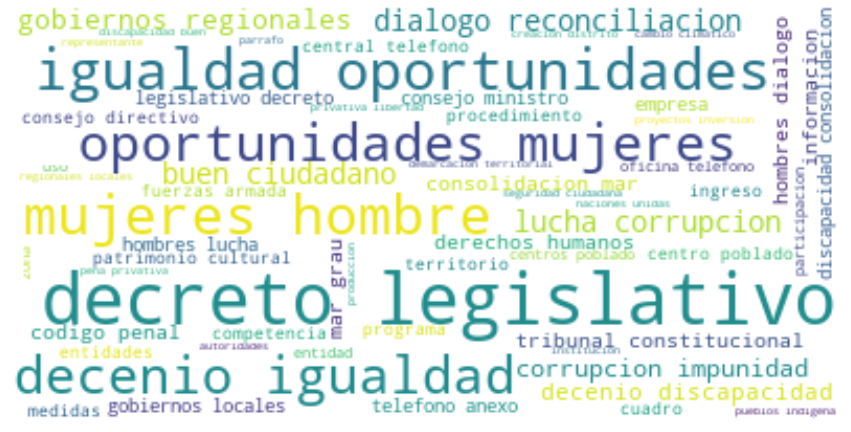

In [17]:
### wordcloud de palabras recurrentes
plt.rcParams["figure.figsize"] = (15,15)
wordcloud = WordCloud(max_words=100,min_font_size=5,max_font_size=50,background_color="white").generate(" ".join(data["Clean_stopword_infor"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

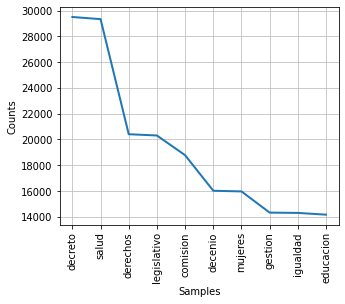

None


In [18]:
## Histogramas de palabras mas frecuentes
plt.rcParams["figure.figsize"] = (5,4)
frequencies = FreqDist( " ".join(data["Clean_stopword_infor"]).split() )
plot = frequencies.plot( 10 )
print(plot)

In [19]:
## Mostrando los ngramas
Ngrams  = ngrams(" ".join(data["Clean_stopword_infor"]).split(), 2)
frequencies = FreqDist( Ngrams )
frequencies.most_common(10)

[(('decreto', 'legislativo'), 16352),
 (('igualdad', 'oportunidades'), 10585),
 (('mujeres', 'hombres'), 9530),
 (('decenio', 'igualdad'), 9419),
 (('oportunidades', 'mujeres'), 9333),
 (('dialogo', 'reconciliacion'), 8236),
 (('buen', 'ciudadano'), 7660),
 (('lucha', 'corrupcion'), 7369),
 (('gobiernos', 'regionales'), 6179),
 (('corrupcion', 'impunidad'), 6089)]

## Word Embbeding - Word2Vec

In [0]:
## Preparando el corpus para el entrenamiento del Word2Vec
wordTeaser=[ i.split() for i in data["Clean_stopword_infor"]]
archivo=open(file='../models/word2vec/models.txt',mode='w',encoding="utf-8")  
for elemento in wordTeaser:
    strg=" ".join(elemento)
    archivo.write(strg +"\n")
archivo.close()

In [0]:
## Construccion del modelo word2vec 
# file = io.open('../models/word2vec/models.txt', mode = 'r', encoding = 'utf-8')
sentences =word2vec.Text8Corpus('../models/word2vec/models.txt')
modelo5 = word2vec.Word2Vec(sentences,size=100,min_count=5)
len(modelo5.wv.vocab)

In [0]:
pickle.dump(modelo5,open("../models/word2vec/modelo5.pkl","wb"))

In [0]:
## obtencion de las 100 palabras mas relevantes
vectorizer = CountVectorizer(max_features=100)
vectorizer.fit_transform(data["Clean_stopword_infor"])
word_freq=vectorizer.get_feature_names()

In [34]:
## construcción el dataframe que representa los vectores de palabra
palabra2vector=[]
for i in modelo5.wv.vocab:
    palabra2vector.append(modelo5.wv[i])  
##analisis de componentes
pca = PCA(n_components=2).fit(np.array(palabra2vector))
pca_2d = pca.transform(palabra2vector)

w2v_df=pd.DataFrame(pca_2d, columns=["x1","x2"])
w2v_df["word"]=modelo5.wv.vocab
print(w2v_df.shape)
# w2v_df=w2v_df.reset_index().set_index("word").drop("index",axis=1)
w2v_df=w2v_df.set_index("word")
w2v_df=w2v_df.loc[word_freq,:]
# w2v_df['word']=w2v_df.index
w2v_df.reset_index(inplace=True)
print(w2v_df.shape)
w2v_df.head()

(13286, 3)
(100, 3)


,word,x1,x2
0,administracion,-6.770849,-1.122938
1,agua,0.583905,-5.993024
2,atencion,-4.716852,-1.659387
3,autoridad,-6.487425,-0.416057
4,bienes,-6.521644,-3.761767


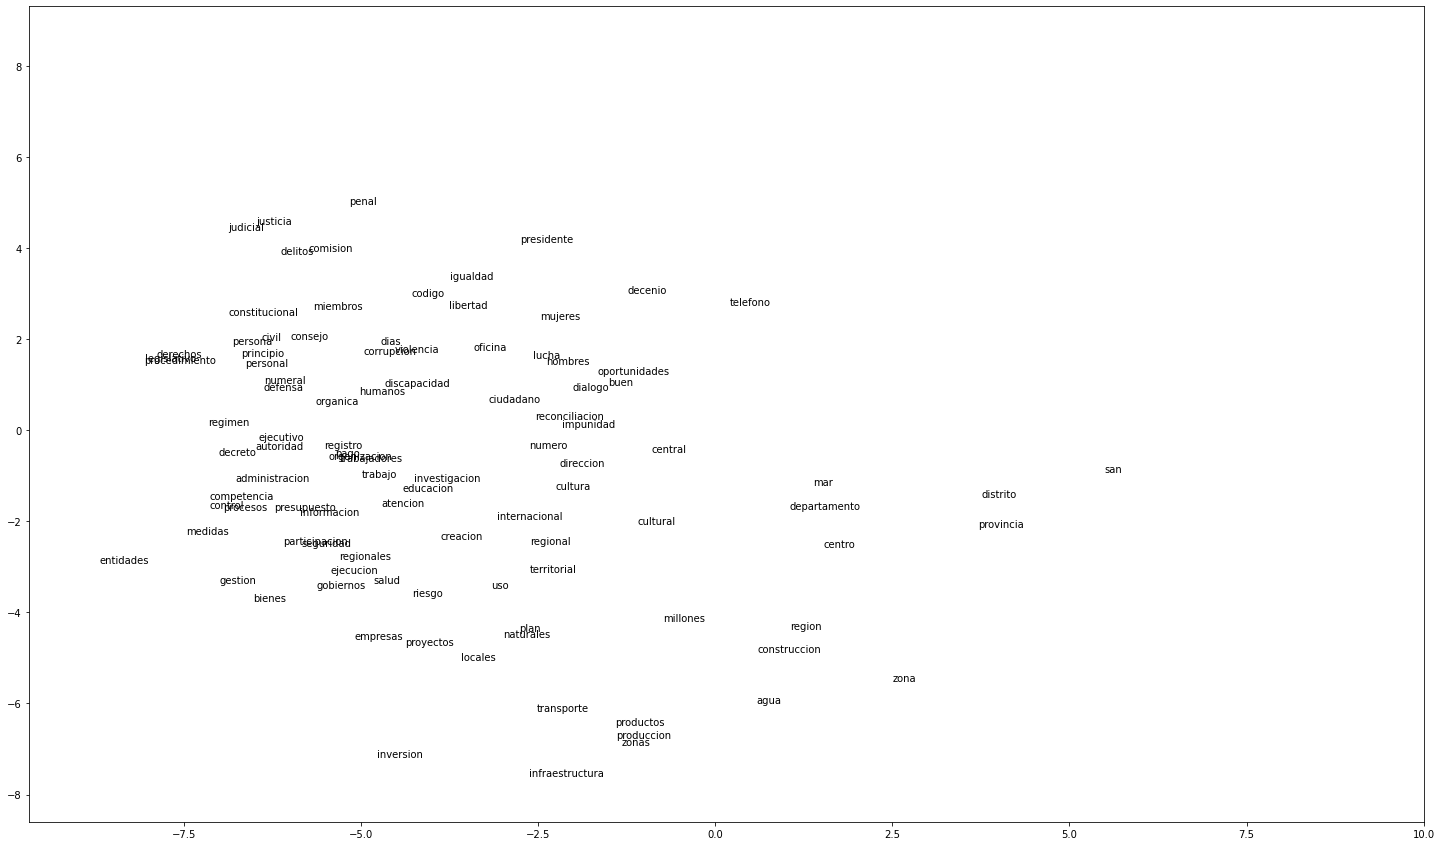

In [36]:
## visualizacion de las relaciones entre palabras
fig, ax = plt.subplots()
for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))  
PADDING = 1.0
x_axis_min = np.amin(pca_2d, axis=0)[0] - PADDING
y_axis_min = np.amin(pca_2d, axis=0)[1] - PADDING
x_axis_max = np.amax(pca_2d, axis=0)[0] + PADDING
y_axis_max = np.amax(pca_2d, axis=0)[1] + PADDING
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (25,15)
plt.show()

In [0]:
## funcion para obtener la representacion vectorial de cada documento usando word2vec
def BusPromVect(noticia):
    vector_palabra = []
    variable = 0
    for i in noticia:
        if i in modelo5.wv.vocab:
            vector_palabra.append(modelo5.wv[i])          
    variable = np.mean(vector_palabra, axis = 0)
    return variable

In [0]:
promVect_train=[]
for noticia in wordTeaser:
    vec_comment_unit = BusPromVect(noticia)
    promVect_train.append(vec_comment_unit)

In [48]:
## Estandarizar los resultados del word2vec
promVect_train=np.asarray(promVect_train)
scaler = StandardScaler() 
scaler.fit(promVect_train)###obtiene el valor de la media y la desviacion estandar
promVect_train = scaler.transform(promVect_train) ### normalizar los datos de entrada para el entrenamiento
print(promVect_train.shape)
aux=pd.DataFrame(promVect_train,index=data.index)
aux

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4849,0.545316,-0.942244,-0.342817,-0.137835,0.198821,1.134820,0.683978,0.388432,-0.897925,-0.555315,-1.938831,-0.010145,-1.256206,0.365490,1.254988,0.309796,-0.208318,-1.564287,1.952477,-1.203521,0.752671,-0.140535,-0.782362,0.009400,-0.441755,-1.095763,-0.232458,-0.178876,-0.792488,0.354327,-0.750893,0.238366,0.778868,-1.031638,1.773794,-1.137029,1.139425,-0.311871,-0.606368,1.153676,...,0.573622,-0.127060,1.263296,0.061396,0.297380,-0.155592,-0.518225,-0.283581,0.033927,-1.786857,0.624237,0.377620,-1.670900,-0.994551,0.133022,0.146492,-0.652741,0.488513,0.178711,-0.901819,-1.052380,-1.824229,-0.800015,-0.882744,-0.306696,-1.645324,-0.472194,0.535107,0.783590,-0.319239,-1.231032,-0.212426,1.109758,-1.046489,0.871377,1.090108,-0.473377,-0.819559,-0.116069,0.011221
4848,-0.112323,-0.456276,-0.543371,0.257420,-0.430567,-1.119807,0.205472,0.223587,-0.929685,-0.815057,-1.356460,-1.369038,-0.010145,-1.815154,1.010661,0.318913,-2.260722,0.091397,0.909068,-1.242285,-0.520206,0.925272,1.623983,-0.571205,-0.151935,0.659510,0.420989,0.570286,-1.077434,0.614395,-1.618503,0.259241,0.024605,0.152082,0.821859,0.496252,1.005871,-0.171083,-0.068964,1.347294,...,-0.625765,0.842135,-0.805805,-0.690294,-0.345265,0.309815,-0.119445,0.658454,-0.763620,-1.106118,-0.234383,0.039272,-0.302804,-0.848650,-1.197581,-0.169658,0.720535,0.226106,0.559670,1.393441,-1.365450,-0.201648,-1.083891,-0.094446,-1.635052,-0.674198,-0.297706,-0.905687,0.280790,-2.322447,-0.317270,0.068967,0.403435,0.136562,0.448324,-0.037275,-0.329145,0.340810,-0.161665,0.199542
4847,0.335927,-1.270193,-0.934098,0.227680,0.468657,1.097944,1.467520,0.153368,-0.820040,-0.229191,-1.258071,0.108214,-1.603152,1.375349,0.682575,-0.389117,-0.608072,-1.076862,2.092994,-1.020603,1.095723,0.811090,-1.036371,-0.380259,-1.990861,-1.552841,-0.923086,-1.191732,-1.372542,-0.203256,-0.341104,0.108681,-0.286775,-1.842453,1.509602,-1.998857,0.667923,0.708168,-1.324548,0.549368,...,0.580977,0.009732,1.326513,0.900659,0.471849,-0.428054,0.175172,0.069102,0.855936,-1.476425,-0.335423,-0.908493,-2.078981,-0.911660,-1.347135,-0.628672,-0.984057,0.348901,0.013224,-1.169409,-0.132772,-2.722515,-0.747461,-0.168533,-0.876742,-1.306967,-0.824081,1.533244,-0.050051,-0.370711,-1.153559,-0.399606,2.050301,-0.615362,-0.514733,1.872620,-0.693531,-1.018998,0.541876,-1.058077
4846,0.373686,0.312800,0.899879,-1.047114,0.516746,-0.331594,1.231404,-0.511062,-0.673822,0.710096,-1.425423,-0.406862,-0.302868,0.447242,0.261095,-0.278944,0.004783,0.772322,-0.173753,0.028168,-2.413528,0.047571,2.428307,-2.267576,-0.240887,0.224594,0.093103,0.973287,0.147945,-0.206515,-0.264234,1.115405,1.834150,0.232984,-0.765587,0.863317,0.423153,-2.458668,0.717870,2.166130,...,0.109070,0.398093,-0.742844,-0.183221,0.201231,-0.303316,0.299477,0.484017,1.774136,-1.828525,-0.395037,-0.818584,1.316167,-0.181078,1.265002,0.908569,-1.000961,0.039692,0.223895,1.316208,0.026839,0.871925,-1.685005,0.228914,-1.570746,-0.369733,-0.208515,-0.069026,-1.574591,0.690013,0.510671,0.462371,0.581269,0.843189,0.248033,-0.523773,-2.111465,0.601320,0.541032,-1.384093
4845,1.020004,0.489797,0.140554,-1.131239,0.236557,-0.387341,2.012057,-0.779531,-0.450712,-1.235471,-0.737255,0.309824,-0.525504,-1.192958,1.579092,0.702965,0.634016,2.028775,-2.363069,-0.062056,-0.635393,0.487476,1.013966,-0.194273,0.577078,-1.119947,-1.813674,0.502011,1.832128,0.208341,-1.431540,0.241003,0.611325,0.453579,-1.303018,2.349212,-0.741797,0.652308,1.446537,-0.144215,...,-0.113105,-1.547317,-3.304106,0.311177,-1.369105,-1.600330,0.469699,1.639691,0.297778,-0.873394,2.491083,1.501243,2.079438,0.559365,0.083519,0.358532,-1.047961,0.864448,-1.144006,0.783766,-0.344054,0.81

In [0]:
pickle.dump(scaler,open("../models/word2vec/scaler.pkl","wb"))

In [49]:
data["word2vec"]=[list(w2v) for w2v in promVect_train]
data.head()

,codigo,fechUlt,fechPres,estado,tituloProy,linkProy,periodo,legislatura,proponente,grupoParlamentario,sumilla,autores,seguimiento,inicAgrupadas,urlPdf,Archivo_Origen,Fecha,NroPaginas,Texto,Clean_Texts,Clean_Stopwords,Clean_stopword_infor,word2vec
index,,,,,,,,,,,,,,,,,,,,,,,
4849,04849/2019-CR,10/09/2019,09/30/2019,Decretado a...,"LEY DE REFORMA CONSTITUCIONAL, QUE ESTABLECE L...",http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,"Frente Amplio por Justicia, Vida y Libertad",Propone modificar el artículo 134 de la Const...,"[Morales Ramírez Edyson Humberto, Foronda Far...",09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484920190930.pdf,2019-09-30,11,Qº“ XCA DEL\n\nº;.\n\nm\n\n5'…»3 Ae Proyecto d...,xca del proyecto ley loncrso congreso republic...,xca proyecto ley loncrso congreso republica ar...,reforma constitucional disolucion convocatoria...,"[0.5453159, -0.9422436, -0.3428167, -0.1378354..."
4848,04848/2019-PE,10/10/2019,09/30/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE CONCEDE LA NACIONAL...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone conceder la nacionalidad peruana a lo...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484820190930.pdf,2019-09-30,5,aT N“….ÍL.€2.LÍ PA de\n\nCONGRESO DE LA REPÚBL...,nilli congreso republica area tramite document...,nilli congreso republica area tramite document...,decenio igualdad oportunidades hombres lucha c...,"[-0.11232288, -0.45627588, -0.54337096, 0.2574..."
4847,04847/2019-PE,10/09/2019,09/30/2019,Decretado a...,LEY QUE MODIFICA EL ARTÍCULO 8 DE LA LEY 28301...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone modificar el artículo 8 de la Ley 283...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484720190930.pdf,2019-09-30,22,CONGRESO DE LA REPÚBLICA\nÁREA DE TRAMITE DOCU...,congreso republica area tramite documentario o...,congreso republica area tramite documentario o...,señor mesa partes pedro carlos presidente voto...,"[0.33592716, -1.270193, -0.93409836, 0.2276804..."
4846,04846/2019-PE,10/10/2019,09/27/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE MODIFICA EL ANEXO D...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone Resolución Legislativa que modifica e...,[],"04/10/2019 Decretado a... Defensa Nacional, O...",None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484620190927.pdf,2019-09-27,15,Proyecto de Resolución Legistativa N”... 731 6...,proyecto resolucion legistativa congreso repub...,proyecto resolucion legistativa congreso repub...,decenio igualdad oportunidades mujeres hombres...,"[0.3736863, 0.3127999, 0.89987934, -1.0471145,..."
4845,04845/2019-CR,10/10/2019,09/25/2019,En comisión,LEY QUE DECLARA DE INTERÉS NACIONAL Y NECESIDA...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,Contigo,Propone declarar de interés nacional y necesi...,"[Violeta López Gilbert Félix, Castro Bravo J...",04/10/2019 Decretado a... Transportes y Comun...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484520190925.pdf,2019-09-25,7,....... CONGRESO DE LA REPÚBLICA\nPÍO)'€CÍO d€...,congreso republica piocio ley ecco ouc sep pro...,congreso republica piocio ley ecco ouc sep pro...,ampliacion mejoramiento asfalto carretera pasa...,"[1.0200036, 0.4897967, 0.14055406, -1.1312388,..."


In [0]:
data.to_pickle("../data/preprocessed/df_preprocessed_w2v.pkl")

In [0]:
import shutil

In [0]:
# shutil.copytree("/content/drive/My Drive/Colab Notebooks/ScrapingProyectosLey/Codigos/Demo","/content/drive/My Drive/Colab Notebooks/Proyectos_Ley_Congreso/notebooks/demo")